In [1]:
import numpy as np
import scipy
import mlpp.pp.hawkes as hk
from mlpp.base.utils import TimeFunction
import matplotlib.pyplot as plt
%matplotlib inline

## Read arguments

In [ ]:
import argparse


## Dataset to simulate 

In [2]:
#mode = 'd10_2blocks_sym'
#mode = 'd10_2blocks_nonsym'
#mode = 'd100_3blocks_sym'
mode = 'd100_3blocks_nonsym'

## Major key for exp kernel: 
### Since hMax=40 encodes the support, we ensure \beta is not too small for estimation
Criterion on exp kernel gives us $\beta_{\min}$ such that $$\exp(-\mbox{hMax} \times \beta_\min) = 10^{-4}$$

In [3]:
hMax = 40
from math import log
beta_min = log(1000) / hMax
print("We have")
print("    beta_min = ",beta_min)

We have
    beta_min =  0.17269388197455343


In [4]:
if mode == 'd10_2blocks_sym':
    d = 10
    mu = 0.05 * np.ones(d)
    blocks = [d/2,d/2]
    L = []
    L.append(np.ones((blocks[0],blocks[0])))
    L.append(2*np.ones((blocks[1],blocks[1])))
    Alpha_true = scipy.linalg.block_diag(*L)
    LL = []
    LL.append(1000*beta_min*np.ones((blocks[0],blocks[0])))
    LL.append(10*beta_min*np.ones((blocks[1],blocks[1])))
    Beta = scipy.linalg.block_diag(*LL)
    # add noise
    #Alpha_true += 0.01
    #Alpha_true[10,17] += 3.
    Alpha_true = .5*(Alpha_true+Alpha_true.T)
    Beta = .5*(Beta + Beta.T)
    Alpha_true /= 12
    
elif mode == 'd10_2blocks_nonsym':
    d = 10
    mu = 0.0005 * np.ones(d)
    Alpha_true = np.zeros((d,d))
    Beta = np.zeros((d,d))
    for i in range(5):
        for j in range(5):
            if i <= j:
                Alpha_true[i][j] = 1.
                Beta[i][j] = 50.
    for i in range(5,10):
        for j in range(5,10):
            if i >= j:
                Alpha_true[i][j] = 1.
                Beta[i][j] = 1.
    Alpha_true /= 6
    
elif mode == 'd100_3blocks_sym':
    d = 100
    mu = 0.0001 * np.ones(d)
    blocks = [d/2,d/2]
    L = []
    L.append(np.ones((blocks[0],blocks[0])))
    L.append(2*np.ones((blocks[1],blocks[1])))
    Alpha_true = scipy.linalg.block_diag(*L)
    LL = []
    LL.append(1000*beta_min*np.ones((blocks[0],blocks[0])))
    LL.append(10*beta_min*np.ones((blocks[1],blocks[1])))
    Beta = scipy.linalg.block_diag(*LL)
    # add noise
    #Alpha_true += 0.01
    Alpha_true[60:70,10:20] += 3.
    Alpha_true = .5*(Alpha_true+Alpha_true.T)
    Beta[60:70,10:20] += 100*beta_min
    Beta = .5*(Beta + Beta.T)
    Alpha_true /= 120
    
elif mode == 'd100_3blocks_nonsym':
    d = 100
    mu = 0.0001 * np.ones(d)
    Alpha_true = np.zeros((d,d))
    Beta = np.zeros((d,d))
    for i in range(40):
        for j in range(40):
            if i <= j:
                Alpha_true[i][j] = 1.
                Beta[i][j] = 10*beta_min
    for i in range(41,60):
        for j in range(41,60):
            Alpha_true[i][j] = 1.
            Beta[i][j] = (100+900*np.random.rand())*100.*beta_min
    for i in range(61,100):
        for j in range(61,100):
            if i >= j:
                Alpha_true[i][j] = 1.
                Beta[i][j] = 100.*beta_min
    Alpha_true /= 30

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


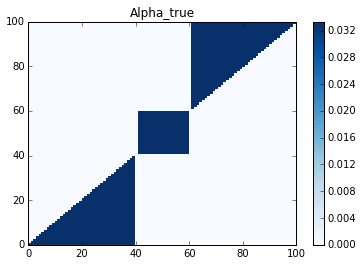

In [5]:
plt.pcolor(Alpha_true,cmap=plt.cm.Blues)
plt.title("Alpha_true")
plt.colorbar()
plt.show()
plt.close()

/Users/massil/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


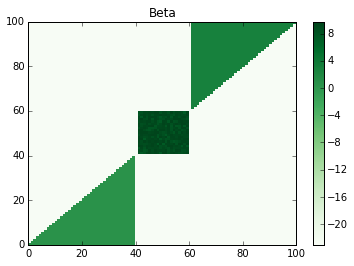

In [6]:
eps = 1e-10
plt.pcolor(np.log(eps+Beta),cmap=plt.cm.Greens)
plt.title("Beta")
plt.colorbar()
plt.show()
plt.close()

### Check if $||\Phi|| = Alpha_{true}$, can generate a stable Hawkes process

In [53]:
_, s, _ = np.linalg.svd(Alpha_true)
print(s.max())
assert s.max() < 1, "Alpha_true cannot generate a stable Hawkes process"

0.859490563247


## Simulation of the process

In [35]:
kernels = [[hk.HawkesKernelExp(a, b) for (a, b) in zip(a_list, b_list)] for (a_list, b_list) in zip(Alpha_true, Beta)]
h = hk.Hawkes(kernels=kernels, mus=list(mu))
T_max = 100000000
h.simulate(T_max)

## Use the class Cumulants

In [43]:
from utils.cumulants import Cumulants
N = h.get_full_process()
cumul = Cumulants(N,hMax=16)
# compute everything
cumul.compute_all()
from scipy.linalg import inv
R_true = inv(np.eye(d)-Alpha_true)
cumul.set_R_true(R_true)
cumul.set_C_th()
cumul.set_K_th()
cumul.compute_B()
cumul.set_K_part()
cumul.set_K_part_th()

In [44]:
from utils.metrics import rel_err
print(rel_err(cumul.C_th,cumul.C))
print(rel_err(cumul.K_th,cumul.K))
print(rel_err(cumul.K_part_th,cumul.K_part))

0.00168842717643
53.2866145284
49.2822287248


In [37]:
with_Beta = True
without_N = True

if with_Beta and without_N:
    cumul.N = None
    data = (cumul,Beta)
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_with_Beta_without_N.pkl.gz','wb')
    pickle.dump(data, f, protocol=2)
    f.close()
    cumul.N = h.get_full_process()
    
elif with_Beta and not without_N:
    data = (cumul,Beta)
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_with_Beta.pkl.gz','wb')
    pickle.dump(data, f, protocol=2)
    f.close()
    
elif not with_Beta and without_N:
    cumul.N = None
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '_without_N.pkl.gz','wb')
    pickle.dump(cumul, f, protocol=2)
    f.close()
    cumul.N = h.get_full_process()

elif not with_Beta and not without_N:
    import gzip, pickle
    f = gzip.open('datasets/' + mode + '.pkl.gz','wb')
    pickle.dump(cumul, f, protocol=2)
    f.close()